In [1]:
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch.nn as nn

c:\Users\mlfav\anaconda3\envs\kjk_py39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
dataset = load_dataset(path=r"C:\Users\mlfav\lib\shlee\color_model\ColorModel", split="train")
dataset.set_format(type="torch", columns=["input_data", "output_color"], dtype=torch.float32)
dataset.shape

c:\Users\mlfav\anaconda3\envs\kjk_py39\lib\site-packages\datasets\load.py:922: FutureWarning: The repository for ColorModel contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at C:\Users\mlfav\lib\shlee\color_model\ColorModel\ColorModel.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


(57225, 2)

In [4]:
total_size = len(dataset)
train_size = int(total_size * 0.6)
valid_size = total_size - train_size
train_data, valid_data = random_split(dataset, [train_size, valid_size])
train_size, valid_size

(34335, 22890)

In [5]:
train_loader = DataLoader(train_data, batch_size=4, shuffle=True, num_workers=2, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=4, shuffle=True, num_workers=2, drop_last=True)

In [6]:
data = train_loader.__iter__().__next__()
input_size = data['input_data'].shape[1]
input_size

119

In [7]:
output_size = data['output_color'].shape
output_size

torch.Size([4, 12])

In [8]:
alpha = 0.001
epochs = 100
dropout_rate = 0.5

In [9]:
class LassoModel(nn.Module):
    def __init__(self, input_size):
        super(LassoModel, self).__init__()
        self.normalize1 = nn.LayerNorm((input_size,))
        self.hidden1 = nn.Linear(input_size, 64)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.normalize2 = nn.LayerNorm((64,))
        self.hidden2 = nn.Linear(64, 32)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(32, 12)

    def forward(self, x):
        x = self.normalize1(x)
        x = torch.nn.functional.relu(self.hidden1(x))
        x = self.dropout1(x)
        x = self.normalize2(x)
        x = torch.nn.functional.relu(self.hidden2(x))
        x = self.dropout2(x)
        x = self.linear(x)
        return x

In [10]:
def lasso_loss(model, h, y):
    mse_loss = nn.functional.mse_loss(h, y)
    
    l1_regularization = alpha * torch.sum(torch.abs(model.linear.weight))
    
    total_loss = mse_loss + l1_regularization
    
    return total_loss

In [11]:
epochs = 100
learning_rate = 0.0002

In [12]:
model = LassoModel(input_size).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [13]:
def train_epoch(train_loader):
    train_loss = []
    for data in train_loader:
        x = data['input_data'].to(device)
        y = data['output_color'].to(device)

        output = model.forward(x)

        loss = lasso_loss(model, output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.cpu().detach().numpy())
    return np.array(train_loss).mean()

def valid_epoch(valid_loader):
    valid_loss = []
    model.eval()
    for data in valid_loader:
        x = data['input_data'].to(device)
        y = data['output_color'].to(device)

        output = model.forward(x)
        loss = lasso_loss(model, output, y)

        valid_loss.append(loss.cpu().detach().numpy())
    return np.array(valid_loss).mean()

In [14]:
train_loss = []
valid_loss = []

for epoch in range(epochs):
    
    t_loss = train_epoch(train_loader)
    v_loss = valid_epoch(valid_loader)
    train_loss.append(t_loss)
    valid_loss.append(v_loss)
    print(f"epoch: {epoch} | train: {t_loss}, valid: {v_loss}")

epoch: 0 | train: 0.24244438111782074, valid: 0.12139268219470978
epoch: 1 | train: 0.10663742572069168, valid: 0.10038011521100998
epoch: 2 | train: 0.09863653779029846, valid: 0.0967046245932579
epoch: 3 | train: 0.09585365653038025, valid: 0.09453532844781876
epoch: 4 | train: 0.09399715065956116, valid: 0.09292998164892197
epoch: 5 | train: 0.09255046397447586, valid: 0.09162068367004395
epoch: 6 | train: 0.0913359522819519, valid: 0.0904836505651474
epoch: 7 | train: 0.0902584120631218, valid: 0.08945669233798981
epoch: 8 | train: 0.0892895832657814, valid: 0.08852449804544449
epoch: 9 | train: 0.08839108049869537, valid: 0.08764658868312836
epoch: 10 | train: 0.08753884583711624, valid: 0.08680125325918198
epoch: 11 | train: 0.08672334253787994, valid: 0.08600056916475296
epoch: 12 | train: 0.0859348475933075, valid: 0.08522689342498779
epoch: 13 | train: 0.08517265319824219, valid: 0.08448643237352371
epoch: 14 | train: 0.08444744348526001, valid: 0.08376481384038925
epoch: 15 |

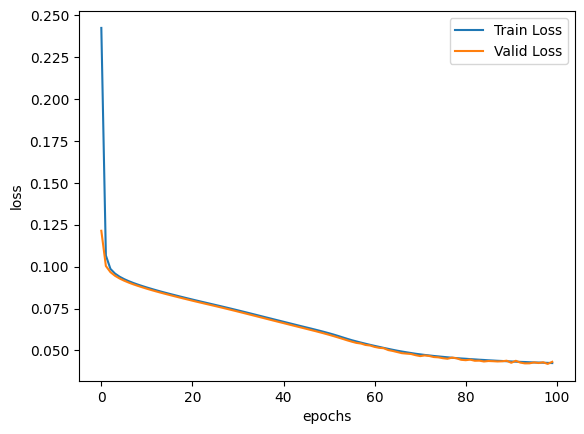

In [15]:
plt.plot([float(loss) for loss in train_loss], label='Train Loss')
plt.plot([float(loss) for loss in valid_loss], label='Valid Loss')
# plt.plot([float(lr[0]) for lr in learning_rates], label='Learning Rate')

plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [16]:
with torch.no_grad():
    data = valid_loader.__iter__().__next__()
    x = data['input_data'].to(device)
    y = data['output_color']
    output = model.forward(x)

In [17]:
print(x[:,:12].shape) # input data
print(y.shape)        # label data
print(output.shape)   # output data

torch.Size([4, 12])
torch.Size([4, 12])
torch.Size([4, 12])


In [18]:
import colorsys

def hsv_to_rgb(hsv_array):
    rgb_array = np.zeros_like(hsv_array)
    for i in range(hsv_array.shape[0]):
        h, s, v = hsv_array[i]
        r, g, b = colorsys.hsv_to_rgb(h.item(), s.item(), v.item())
        rgb_array[i] = np.array([r, g, b])

    return rgb_array

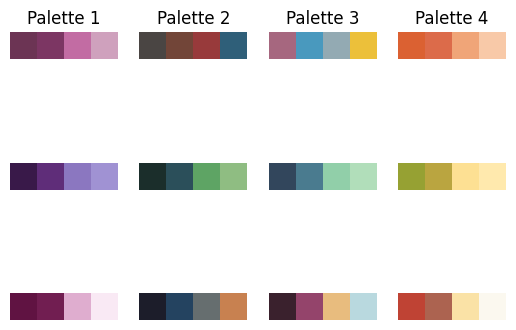

In [26]:
batch_size = 4
for b in range(batch_size):
    rgb = x[:,:12][b].cpu().detach().numpy().reshape((4,3)) # input colors
    label = y[b].numpy().reshape((4,3)) # label color
    label = hsv_to_rgb(label).reshape((4,3))
    val = output[b].cpu().detach().numpy().reshape((4,3)) # return color
    val = hsv_to_rgb(val).reshape((4,3))
    val = np.clip(val, 0, 1)
    
    plt.subplot(3, batch_size, 1+b)
    plt.imshow([rgb])
    plt.axis(False)
    plt.title(f'Palette {b+1}')
    plt.subplot(3, batch_size, b+1+batch_size)
    plt.imshow([val])
    plt.axis(False)

    plt.subplot(3, batch_size, b+1+batch_size*2)
    plt.imshow([label])
    plt.axis(False)


In [27]:
PATH = './Model/model.pt'
torch.save(model.state_dict(), PATH)

In [29]:
model

LassoModel(
  (normalize1): LayerNorm((119,), eps=1e-05, elementwise_affine=True)
  (hidden1): Linear(in_features=119, out_features=64, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (normalize2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (hidden2): Linear(in_features=64, out_features=32, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

In [33]:
model.state_dict()

OrderedDict([('normalize1.weight',
              tensor([1.0050, 1.0002, 1.0047, 1.0027, 1.0049, 1.0020, 1.0001, 1.0027, 1.0058,
                      1.0005, 0.9958, 1.0043, 1.0125, 1.0164, 1.0078, 1.0191, 1.0237, 1.0079,
                      1.0157, 1.0181, 1.0009, 1.0136, 1.0053, 1.0091, 1.0014, 1.0011, 1.0073,
                      1.0016, 0.9986, 1.0012, 1.0016, 0.9959, 1.0017, 0.9990, 0.9954, 1.0057,
                      1.0023, 1.0002, 1.0036, 1.0078, 0.9974, 1.0013, 1.0015, 0.9983, 0.9998,
                      1.0044, 1.0050, 0.9994, 1.0038, 0.9962, 1.0017, 1.0037, 1.0040, 0.9995,
                      1.0266, 1.0044, 1.0145, 1.0109, 1.0241, 0.9996, 1.0236, 1.0034, 1.0258,
                      1.0254, 1.0180, 1.0014, 1.0005, 1.0008, 1.0041, 1.0033, 1.0055, 0.9984,
                      0.9996, 1.0028, 1.0004, 1.0001, 1.0013, 1.0057, 1.0019, 1.0034, 1.0042,
                      0.9999, 1.0065, 1.0027, 1.0015, 0.9993, 0.9985, 0.9993, 0.9959, 1.0015,
                      1.0